In [1]:
import simulation
import numpy as np
import makemap
import matplotlib as mpl
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
from matplotlib import gridspec
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text',usetex=True)

import pylab as plt

%matplotlib inline

/home/mart/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
Ebins = np.logspace(0,3,101)
dE = (Ebins[1:]-Ebins[0:-1])
Emean = (Ebins[1:]+Ebins[0:-1])/2.
spec = 1e-9*Emean**-2.2
E3fgl = np.logspace(-1,2,101)
E3fgl_mean = (E3fgl[1:]+E3fgl[:-1])/2.
mask_E3FGL = (Emean>=1)&(Emean<100)

In [59]:
bins_3fgl = np.logspace(-16,-8,32)
bins_3fgl_mean = (bins_3fgl[1:]+bins_3fgl[0:-1])/2.

In [60]:
##Read 3FGL
fl = 'gll_psc_v16.fit'
fl = 'gll_psch_v13.fit'

flux_3fgl,spec_3fgl = simulation.read_catalog(fl,Emean,classes=['pwn','spp','snr','psr','lat'])

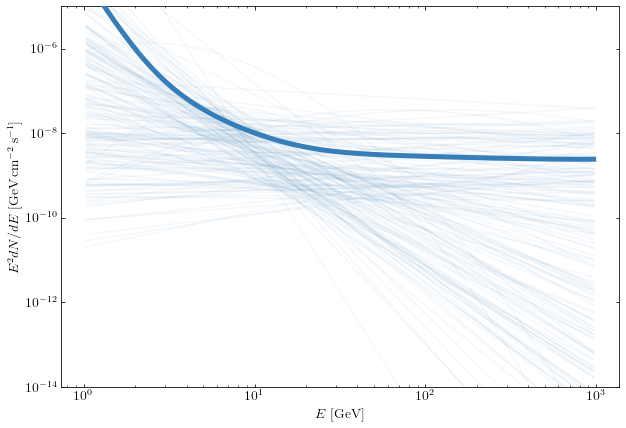

In [61]:
f,ax = plt.subplots(1,figsize=(10,7))
for sp in spec_3fgl:
    ax.loglog(Emean,Emean**2*sp,color=c2,alpha=0.05,zorder=1)
    
ax.loglog(Emean,Emean**2*np.mean(spec_3fgl,axis=0),color=c2,alpha=1,lw=5,zorder=10)
ax.set_ylim([1e-14,1e-5])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
#ax.get_yaxis().set_ticks([])
ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$",fontsize=14)
ax.set_xlabel(r"$E$ [GeV]",fontsize=14)
plt.legend(frameon=False,fontsize=14,loc=1)

In [62]:
def rebin(x, nrebin,mean = False, quadratic = False):
    g = 2. if quadratic else 1.
    if mean:
        return ((x**g).reshape(-1, nrebin).mean(axis=1))**(1./g)
    else:
        return ((x**g).reshape(-1, nrebin).sum(axis=1))**(1./g)

In [63]:
###Diffuse pion

###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.

import open_dat
from scipy.optimize import curve_fit
lb = [(180,20),(180,1),(20,20),(20,1)]

modelfunc = lambda x,p1,p2: p1-p2*x
model27 = lambda x,p: p-2.7*x  
plotfunc = lambda E,a,b: b*(E)**-a

spec_diff_lb = []

for ilb in lb:
    datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = simulation.read_datfile(datfile)
    mask_E_diff = E_diff > 2
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
    err = error[mask_E_diff]

    fit,cov = curve_fit(modelfunc,np.log10(E_diff),np.log10(spec),p0=[-7,2.7],sigma=err/spec)
    fitted_spec = plotfunc(Emean,fit[1],10**fit[0]) ##If this is a softer spectra this matters a lot!
    fit27,cov27 = curve_fit(model27,np.log10(E_diff),np.log10(spec),p0=[-7],sigma=err/spec)
    
    ####This matters a lot!
    diff_index = fit[1]
    fitted_spec = plotfunc(Emean,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!

    spec_diff_lb.append(fitted_spec)

In [64]:
def fraction(N,a,Lmin,Lmax,thres):
    spec_sim,flux_sim,lb_sim = simulation.source_sim(N,a,Lmin,Lmax,spec_3fgl,Emean,dE,thres)
    l_sim = lb_sim[0,:]
    b_sim = lb_sim[1,:]
    fluxmask = flux_sim < thres
    flux_unres = flux_sim[fluxmask]
    l_unres = l_sim[fluxmask]
    b_unres = b_sim[fluxmask]
    frac_lb = []
#     plt.figure()
#     for sp in spec_sim[fluxmask][::100]:
#         plt.loglog(Emean,Emean**2*sp,alpha=0.3)
#     plt.ylim([1e-14,1e-8])
#     plt.loglog(Emean,Emean**2*np.mean(spec_sim[fluxmask],axis=0),color='black',lw=5)
    for ilb,_lb in enumerate(lb):
        diff_lb = spec_diff_lb[ilb]
        lmask = l_sim<=_lb[0]
        bmask = b_sim<=_lb[1]
        totalspec = np.sum(spec_sim[fluxmask&bmask&lmask],axis=0)
        frac = totalspec/diff_lb
        frac_lb.append(frac)
#         plt.loglog(Emean,frac,label=_lb)
#     plt.legend()
#     plt.ylim([0.01,1])
    mp = makemap.makemap(l_unres,b_unres,flux_unres,0.5)
    hist = np.histogram(flux_sim,bins=bins_3fgl)[0]
    return mp,frac_lb,spec_sim,hist

In [67]:
n = 10
nrebin = 10
lspace = np.linspace(180,-180,720)
bspace = np.linspace(-90,90,361) #map
bcut = 20.25
maskb = np.abs(bspace)<=bcut

mp_list = []
frac_list = []
l_list = []
b_list = []
hist_list = []
for i in range(n):
    mp,frac_lb,specs,hists = fraction(29000,1.8,5e32,5e37,1e-9)
    unres_l = np.sum(mp[maskb][:,:],axis=0)
    unres_b = np.sum(mp[maskb],axis=1)
    frac_list.append(frac_lb)
    l_list.append(rebin(unres_l,nrebin,mean=True))
    b_list.append(unres_b)
    hist_list.append(hists)


l_list = np.array(l_list)
hist_list = np.array(hist_list)
hist_mean = np.mean(hist_list,axis=0)
hist_max = np.amax(hist_list,axis=0).astype('float')
hist_min = np.amin(hist_list,axis=0).astype('float')
hist_min[hist_min==0]=1e-5
hist_max[hist_max==0]=1e-5
frac_list = np.array(frac_list)
frac = np.mean(frac_list,axis=0)
frac_std = np.std(frac_list,axis=0)
frac_min = np.amin(frac_list,axis=0)
frac_max = np.amax(frac_list,axis=0)

(0.1, 10000.0)

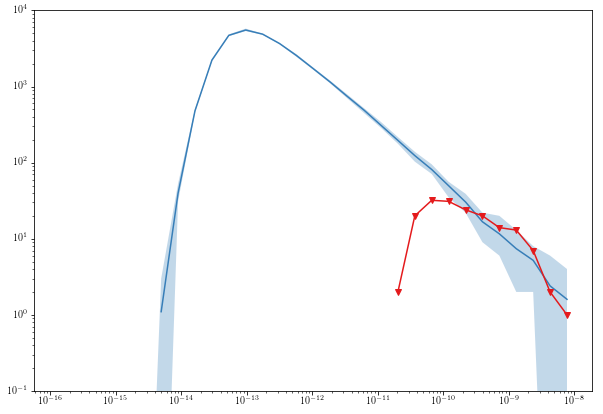

In [68]:
f,ax = plt.subplots(1,figsize=(10,7))
ax.loglog(bins_3fgl_mean,hist_mean)
ax.fill_between(bins_3fgl_mean,hist_min,hist_max,alpha=0.3)
ax.set_yscale('log',nonposy='clip')
hist_3fgl = np.histogram(flux_3fgl,bins=bins_3fgl)[0]
ax.loglog(bins_3fgl_mean,hist_3fgl,marker='v')
ax.set_ylim([1e-1,1e4])

(5e-11, 1e-05)

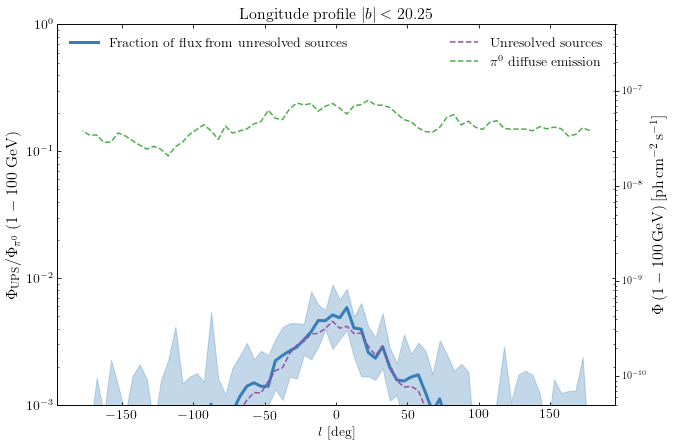

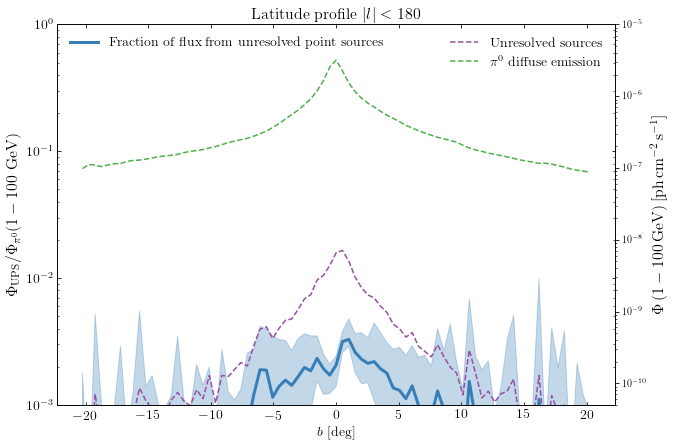

In [69]:
###Fraction flux l,b

nrebin=10
all_gr = np.loadtxt('all_gr.dat')*7.6e-5 ##sr
lspace_gr = np.linspace(180,-180,720)
bspace_gr  = np.linspace(-20.25,20.25,all_gr.shape[0])
lmask = np.abs(lspace_gr)<1e3
bmask = np.abs(bspace_gr)<=bcut
all_gr_l = np.sum(all_gr[bmask][:,lmask],axis=0)

all_gr_b = np.sum(all_gr[:,lmask][bmask,:],axis=1)

l_unres_mean = np.mean(l_list,axis=0)
l_unres_min = np.amin(l_list,axis=0)
l_unres_max = np.amax(l_list,axis=0)

b_unres_mean = np.mean(b_list,axis=0)
b_unres_min = np.amin(b_list,axis=0)
b_unres_max = np.amax(b_list,axis=0)

lspace = rebin(lspace_gr,nrebin,mean=True)
bspace = bspace_gr
all_gr_l = rebin(all_gr_l,nrebin,mean=True)


f,ax = plt.subplots(1,figsize=(10,7))

ax.plot(lspace,l_unres_mean/all_gr_l,zorder=10,lw=3,color=c2,label='Fraction of flux from unresolved sources')
ax.fill_between(lspace,l_unres_min/all_gr_l,l_unres_max/all_gr_l,alpha=0.3,color=c2)
ax2 = ax.twinx()
ax2.plot(lspace,l_unres_mean,color=c4,ls='--',label='Unresolved sources')
ax2.plot(lspace,all_gr_l,color=c3,ls='--',label=r'$\pi^0$ diffuse emission')
ax2.set_yscale('log',nonposy='clip')
ax.set_yscale('log',nonposy='clip')
ax.set_ylim([1e-3,1])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
#ax.get_yaxis().set_ticks([])
ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}\ (1-100 \rm \ GeV)$",fontsize=16)
ax.set_xlabel(r"$l$ [deg]",fontsize=14)
ax2.set_ylabel(r"$\rm \Phi\, (1-100\, GeV)\,[ph\,cm^{-2}\,s^{-1}]$",fontsize=16)
ax.legend(frameon=False,fontsize=14,loc=2)
ax2.legend(frameon=False,fontsize=14,loc=1)
ax2.set_ylim([5e-11,5e-7])
ax.set_title(r'Longitude profile $|b|<20.25$',fontsize=16)
f,ax = plt.subplots(1,figsize=(10,7))

ax.plot(bspace,b_unres_mean/all_gr_b,zorder=10,lw=3,color=c2,label='Fraction of flux from unresolved point sources')
ax.fill_between(bspace,b_unres_min/all_gr_b,b_unres_max/all_gr_b,alpha=0.3,color=c2)
ax2 = ax.twinx()
ax2.plot(bspace,b_unres_mean,color=c4,ls='--',label='Unresolved sources')
ax2.plot(bspace,all_gr_b,color=c3,ls='--',label=r'$\pi^0$ diffuse emission')
ax2.set_yscale('log',nonposy='clip')
ax.set_yscale('log',nonposy='clip')
ax.set_ylim([1e-3,1])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
#ax.get_yaxis().set_ticks([])
ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0} (1-100 \rm \ GeV)$",fontsize=16)
ax.set_xlabel(r"$b$ [deg]",fontsize=14)
ax2.set_ylabel(r"$\rm \Phi\, (1-100\, GeV)\,[ph\,cm^{-2}\,s^{-1}]$",fontsize=16)
ax.legend(frameon=False,fontsize=14,loc=2)
ax2.legend(frameon=False,fontsize=14,loc=1)
ax.set_title(r'Latitude profile $|l|<180$',fontsize=16)
ax2.set_ylim([5e-11,1e-5])

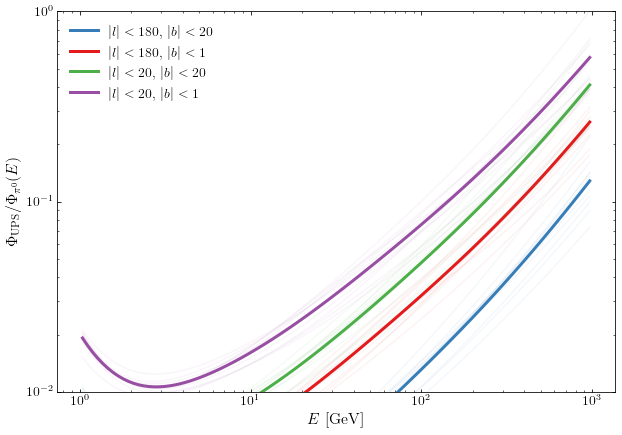

In [70]:
f,ax = plt.subplots(1,figsize=(10,7))
for ilb,_lb in enumerate(lb):
    line, = ax.loglog(Emean,frac[ilb],label=r"$|l| < %s$, $|b|<%s$"%(_lb[0],_lb[1]),lw=3,zorder=1)
    color = line.get_color()
    for fl in frac_list:
        ax.loglog(Emean,fl[ilb],alpha=0.05,color=color,zorder=1)

ax.set_ylim([1e-2,1])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
#ax.get_yaxis().set_ticks([])
ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=16)
ax.set_xlabel(r"$E$ [GeV]",fontsize=16)
plt.legend(frameon=False,fontsize=14,loc=0)

In [71]:
def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def add_spec(spec,flux,dE,mask):
    wrong_spec = np.outer(flux,spec)
    norm = np.sum(wrong_spec[:,mask]*dE[mask][np.newaxis,:],axis=1)
    good_spec = wrong_spec*flux[:,np.newaxis]/norm[:,np.newaxis]
    return good_spec

def add_rand_spec(spec,flux,dE,mask):
    wrong_spec = flux[:,np.newaxis]*spec
    norm = np.sum(wrong_spec[:,mask]*dE[mask][np.newaxis,:],axis=1)
    good_spec = wrong_spec*(flux[:,np.newaxis]/norm[:,np.newaxis])
    return good_spec

In [ ]:
randspec = spec_3fgl[np.random.randint(0,spec_3fgl.shape[0],200)]
flux = np.random.random(200)
maskE = (Emean>1)&(Emean<100)

In [ ]:
spec = add_rand_spec(randspec,flux,dE,maskE)